# Intrinsic Camera Calibration of GoPro with OpenCV ChAruCo pattern

### Goal

The goal of this notebook is to calibrate the intrinsic parameter $K$ of the camera.  Given a number of chessboard (charuco) images, this notebook first detects the corner positions in each image, and then finds the camera pose of each frame and the camera intrinsic parameters.

* Input:  $n$ chessboard images (= the 2D corner position $x$ and the corresponding 3D position $X$ in the world (chessboard) coordinate system)
* Output: intrinsic parameter $K$, distortion coefficients $d$, $n$ camera poses $R_i, t_i$ w.r.t. the chessboard

To have a better / robust estimation of $K$, the chessboard should be captured as large as possible in the DoF in different poses.


Notice:
* The chessboard coordinate system serves as the world coordinate system.
* Though we obtain $R, t$ as a result, we are not interested in them in this scenario.


### Projection model

Please check the OpenCV document for the detail. 
* https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html#details

In short, a 3D point $X$ in the world coordinate system (WCS) is transformed to the camera coordinate system (CCS) by a roation $R$ and a translation $t$, and then projected to $x$ by $K$:
\begin{equation}
\tilde{x} \sim K \begin{bmatrix}
R \: | \: t
\end{bmatrix}
\tilde{X}.
\end{equation}


## Libraries

In [1]:
import sys, os, cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pycalib.plot import plotCamera


## Calibration parameters

**Important**
* Compare the pattern shown below with the pattern captured in the image.
* The numbers of rows and cols indicate **the numbers of CELLs, not corners**.
  * For example, an 18x9 ChAruco board has a 18 cells == 17 corners by 9 cells == 8 corners pattern.
  * In the case of the traditional chessboard, the rows and cols indicate the numbers of corners.

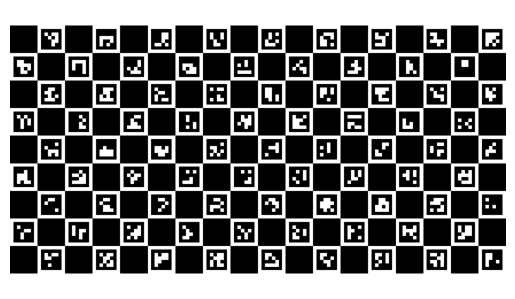

In [2]:
# Chessboard configuration

aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)
board = cv2.aruco.CharucoBoard((18, 9), 0.02, 0.015, aruco_dict)

# check if the board is correct
image = board.generateImage((1280, 720))

plt.figure()
plt.imshow(image, cmap='gray')
#plt.title('DICT_4X4_250 6x5 ChAruco pattern')
plt.axis('off')
plt.show()

# Input images capturing the chessboard above
input_files = '../data/charuco/*.jpg'

## 2D corner detection

../data/charuco/00000001.jpg  found 136 corners
../data/charuco/00000002.jpg  found 136 corners
../data/charuco/00000003.jpg  found 136 corners
../data/charuco/00000004.jpg  found 136 corners
../data/charuco/00000005.jpg  found 136 corners
../data/charuco/00000006.jpg  found 136 corners
../data/charuco/00000007.jpg  found 136 corners
../data/charuco/00000008.jpg  found 136 corners
../data/charuco/00000009.jpg  found 136 corners
(9, 136, 1, 3) (9, 136, 1, 2)


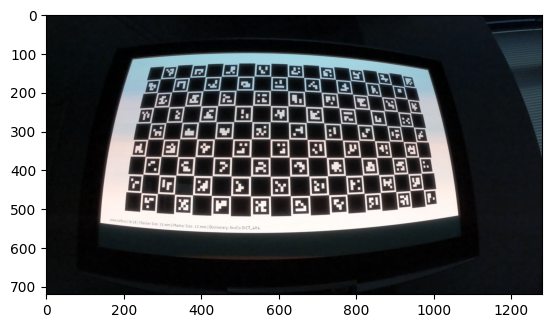

In [3]:
parameters =  cv2.aruco.DetectorParameters()
parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_CONTOUR
detector = cv2.aruco.CharucoDetector(board, detectorParams=parameters)

all_obj_pts = []
all_img_pts = []
all_ids = []

for i in sorted(glob(input_files)):
    frame = cv2.imread(i)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    c_corners, c_ids, corners, ids = detector.detectBoard(gray)
    ret = len(c_corners)
    print(f'{i}  found {ret} corners')
    if ret > 0:
        objPoints, imgPoints = board.matchImagePoints(c_corners, c_ids)
        all_obj_pts.append(objPoints)
        all_img_pts.append(imgPoints)
        all_ids.append(c_ids)

    imsize = (gray.shape[1], gray.shape[0])

all_obj_pts = np.array(all_obj_pts)
all_img_pts = np.array(all_img_pts)

print(all_obj_pts.shape, all_img_pts.shape)

# show sample image
plt.figure()
plt.imshow(frame)
plt.show()

## Calibration

In [5]:
#ret, K, d, rvec, tvec = cv2.aruco.calibrateCameraCharuco(all_corners, all_ids, board, imsize, None, None,
#                                                         flags=cv2.CALIB_FIX_ASPECT_RATIO + cv2.CALIB_RATIONAL_MODEL)

ret, K, d, rvec, tvec = cv2.calibrateCamera(all_obj_pts, all_img_pts, imsize, None, None, flags=cv2.CALIB_FIX_ASPECT_RATIO + cv2.CALIB_RATIONAL_MODEL)

print("Image size = ", imsize)
print("Reprojection error = ", ret)
print("Intrinsic parameter K = ", K)
print("Distortion parameters d = (k1, k2, p1, p2, k3, k4, k5, k6) = ", d)

assert ret < 1.0


Image size =  (1280, 720)
Reprojection error =  0.3010951580606194
Intrinsic parameter K =  [[586.82908524   0.         641.01812808]
 [  0.         586.82908524 356.16960629]
 [  0.           0.           1.        ]]
Distortion parameters d = (k1, k2, p1, p2, k3, k4, k5, k6) =  [[ 5.70126130e-01 -5.70435346e-01  3.89275117e-04 -5.89263800e-04
  -4.88942040e-02  8.65418192e-01 -5.13053770e-01 -1.78884281e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
